In [1]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris
from pandas import Series, DataFrame

%matplotlib inline

### Movie info

In [2]:
# Read in the data as movie_info
# Use parse_dates and pass column name to read it as a datetime
movie_info = pd.read_csv('Data/rt.movie_info.tsv', encoding='latin-1', sep='\t', 
                        parse_dates=['theater_date', 'dvd_date'])
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09,2001-09-25,NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,2013-01-01,$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13,2000-04-18,NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,1997-08-27,NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaT,NaT,NaN,NaN,200 minutes,NaN


In [3]:
movie_info.columns

Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')

In [4]:
# Info on the dataframe
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            1560 non-null   int64         
 1   synopsis      1498 non-null   object        
 2   rating        1557 non-null   object        
 3   genre         1552 non-null   object        
 4   director      1361 non-null   object        
 5   writer        1111 non-null   object        
 6   theater_date  1201 non-null   datetime64[ns]
 7   dvd_date      1201 non-null   datetime64[ns]
 8   currency      340 non-null    object        
 9   box_office    340 non-null    object        
 10  runtime       1530 non-null   object        
 11  studio        494 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 146.4+ KB


### Cleaning the data

In [5]:
#checking how many null values there are in each column
movie_info.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

To clean my columns from the null values, I will be replacing the values in some of the columns with 'Missing" so that it's all consistent across the columns

In [6]:
#Fill the missing values in synposis, genre, director, writer, currency, studio with 'Missing'
movie_info['synopsis'].fillna('Missing', inplace=True)
movie_info['genre'].fillna('Missing', inplace=True)
movie_info['director'].fillna('Missing', inplace=True)
movie_info['writer'].fillna('Missing', inplace=True)
movie_info['currency'].fillna('Missing', inplace=True)
movie_info['studio'].fillna('Missing', inplace=True)


In [7]:
#Fill theater_date and dvd_date missing values with a generic date "1800-01-01" to keep same format
movie_info['theater_date'].fillna('1800-01-01', inplace=True)
movie_info['dvd_date'].fillna('1800-01-01', inplace=True)

In [8]:
#Fill box_office missing valus with 0
movie_info['box_office'].fillna(0, inplace=True)

### Step 1: let's look at the different variables within this data frame to see what factors contribute to successful movies


### We will first look at Runtime across movies, what's the most used runtime, what's the average?

In [9]:
movie_info['runtime'].value_counts()

90 minutes     72
95 minutes     66
100 minutes    51
93 minutes     47
96 minutes     43
               ..
13 minutes      1
64 minutes      1
57 minutes      1
5 minutes       1
10 minutes      1
Name: runtime, Length: 142, dtype: int64

In [10]:
movie_info['runtime']

0       104 minutes
1       108 minutes
2       116 minutes
3       128 minutes
4       200 minutes
           ...     
1555    106 minutes
1556     88 minutes
1557    111 minutes
1558    101 minutes
1559     94 minutes
Name: runtime, Length: 1560, dtype: object

We will change the type of runtime column into actual numbers so we can work on it

In [11]:
movie_info['runtime'] = movie_info['runtime'].str.replace('minutes',"")
movie_info['runtime'] = pd.to_numeric(movie_info['runtime'])

In [12]:
#to confirm that the type has changed
movie_info['runtime'].dtype

dtype('float64')

In [13]:
lowest_five_runtime = movie_info.sort_values('runtime', ascending=True)
lowest_five_runtime.head(5)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1358,1753,Carmel Myers' co-star in this amusing farce is...,NR,Comedy,Paul Powell,Missing,1800-01-01,1800-01-01,Missing,0,5.0,Missing
540,707,James Pierce is one of the lesser-known film T...,NR,Action and Adventure,Missing,Missing,1800-01-01,1800-01-01,Missing,0,6.0,Missing
273,361,Missing,NR,Drama|Special Interest,Roberto Sanchez Santos,Missing,1800-01-01,1800-01-01,Missing,0,7.0,Missing
950,1229,A short fashion film.,NR,Documentary,Missing,Missing,1800-01-01,1800-01-01,Missing,0,10.0,Missing
983,1275,"Desperately seeking to save his marriage, Bren...",NR,Drama,Jen McGowan,Colin Pink|Jen McGowan,1800-01-01,1800-01-01,Missing,0,11.0,Missing


In [14]:
highest_five_runtime = movie_info.sort_values('runtime', ascending=False)
highest_five_runtime.head(5)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
639,823,Directed by Marco Tullio Giordana and La Megli...,R,Art House and International|Drama|Romance,Marco Tullio Giordana,Stefano Rulli|Sandro Petraglia,2003-06-22 00:00:00,2006-02-07 00:00:00,Missing,0,358.0,Miramax Films
508,666,"After twenty-five years, a trio of old high sc...",NR,Drama|Mystery and Suspense,Paul Wendkos,Missing,1800-01-01,1800-01-01,Missing,0,313.0,Missing
1111,1434,When a pay cut sends Australian dock workers o...,NR,Drama|Romance,Chris Thomson,Missing,1800-01-01,1800-01-01,Missing,0,294.0,Missing
1490,1918,A collection of 15 chapters from Tarzan and th...,NR,Action and Adventure|Classics|Documentary,Henry MacRae|Harry McRae,William Lord Wright|Ian McCloskey Heath,1929-10-01 00:00:00,2006-10-24 00:00:00,Missing,0,290.0,Missing
1029,1332,Based on the classic Nathaniel Hawthorne novel...,NR,Drama|Television,Rick Hauser,Missing,1800-01-01,1800-01-01,Missing,0,240.0,Missing


In [15]:
print(movie_info['runtime'].min())
print(movie_info['runtime'].max())

5.0
358.0


Mean Value for Runtime column: 103.96797385620916
Median Value for Runtime column: 100.0


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


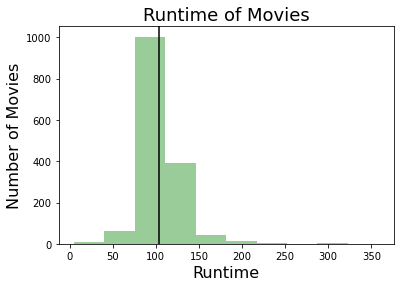

In [16]:
runtime_mean = movie_info['runtime'].mean()
runtime_median = movie_info['runtime'].median()

sns.distplot(movie_info['runtime'],kde=False, color='green', bins=10)
plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
plt.title('Runtime of Movies', fontsize=18)
plt.xlabel('Runtime', fontsize=16)
plt.ylabel('Number of Movies', fontsize=16);

# # fig, ax = plt.subplots()

# sns.histplot(data=movie_info, x=['runtime']
# # plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
# # ax.set_title("Runtime of Movies")
# # ax.set_xlabel("Runtime")
# # ax.set_ylabel("Number of Movies")

print("Mean Value for Runtime column: {}".format(runtime_mean))
print("Median Value for Runtime column: {}".format(runtime_median))

In [17]:
#previous method i used before seaborn
# runtime_mean = movie_info['runtime'].mean()
# runtime_median = movie_info['runtime'].median()

# fig, ax = plt.subplots()

# ax.hist(movie_info['runtime'])
# plt.axvline(x = movie_info['runtime'].mean(), color = 'black')
# ax.set_title("Runtime of Movies")
# ax.set_xlabel("Runtime")
# ax.set_ylabel("Number of Movies")

# print("Mean Value for Runtime column: {}".format(runtime_mean))
# print("Median Value for Runtime column: {}".format(runtime_median))

From the visualization above, we can see the data has a slightly positive skew.
Almost 1000 movies have an average of 103 minutes of running time and a median 100.

**Dropping rows that contain missing values:** runtime column contains 30 null values in this case we will simply drop any rows that contain them. The number dropped does not constitute a significant portion of our dataset, so dropping the values is an acceptable loss

In [18]:
movie_info = movie_info.dropna(subset=['runtime'])
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

### let's check the rating and see what's the most popular rating

In [19]:
movie_info['rating'].value_counts()

R        519
NR       482
PG       239
PG-13    232
G         57
NC17       1
Name: rating, dtype: int64

In [20]:
movie_info['rating'].dtype

dtype('O')

In [21]:
# There are only 3 null values so let's drop them from the rating column 
movie_info = movie_info.dropna(subset=['rating'])
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

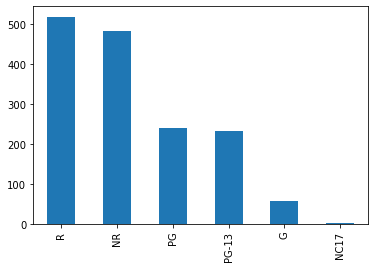

In [22]:
# now let's visualize it
movie_info['rating'].value_counts().plot(kind='bar');


C:\Users\dtaher\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


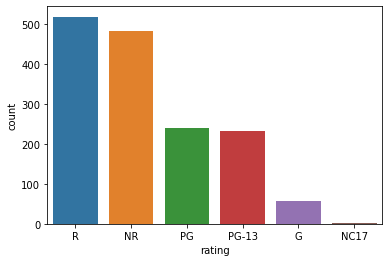

In [23]:
#I want to try seaborn visualization
sns.countplot(movie_info['rating']);

The graph shows us that the majority of movies are rated R

### Now let's examine the director column and see what we can extract from there
Is there a certain Director that is more successful than others that potentially could be hired to direct the movies?

In [24]:
movie_info['director'].value_counts()

Missing                         185
Steven Spielberg                 10
Clint Eastwood                    8
Ridley Scott                      4
Bruce Beresford                   4
                               ... 
Norman Taurog|Busby Berkeley      1
Doug Liman                        1
Busby Berkeley                    1
Jack Bender                       1
Michael Haneke                    1
Name: director, Length: 1116, dtype: int64

Inspired by Leo's work since he had already worked on director column

In [25]:
#I will use the same thing Leo used to split genres by Director
s = movie_info['genre'].str.split('|').apply(Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'genres'
# del movie_info['genre'] (I don't want to delete from my original dataframe)
movie_split_genres = movie_info.join(s)

In [26]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,1996-09-13 00:00:00,2000-04-18 00:00:00,Missing,0,116.0,Missing
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09 00:00:00,1997-08-27 00:00:00,Missing,0,128.0,Missing
4,7,Missing,NR,Drama|Romance,Rodney Bennett,Giles Cooper,1800-01-01,1800-01-01,Missing,0,200.0,Missing


In [27]:
movie_split_genres = movie_split_genres.drop('genre', axis=1)

In [28]:
movie_split_genres.head()

,id,synopsis,rating,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genres
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108.0,Entertainment One,Drama
1,3,"New York City, not-too-distant-future: Eric Pa...",R,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17 00:00:00,2013-01-01 00:00:00,$,"600,000",108.0,Entertainment One,Science Fiction and Fantasy


In [29]:
#continuing with Leo's work

# using the groupby function on the director column

# first i will split the objects 
# then apply a function
# then combine those results 

# made this into a variable so that i dont have to write the same code
movie_dir = movie_split_genres.groupby(['director'])

# what i get back is a dataframe groupby object

In [30]:
# this returns a dataframe with the director info
# this is like running a filter on the original dataframe
movie_dir.get_group('William Friedkin')

,id,synopsis,rating,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genres
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Action and Adventure
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Classics
0,1,"This gritty, fast-paced, and innovative police...",R,William Friedkin,Ernest Tidyman,1971-10-09 00:00:00,2001-09-25 00:00:00,Missing,0,104.0,Missing,Drama
13,20,Rachel (Britt Ekland) is an Amish girl who rej...,PG-13,William Friedkin,Sidney Michaels|Arnold Schulman|Norman Lear,1968-12-22 00:00:00,2008-05-20 00:00:00,Missing,0,97.0,Missing,Classics
13,20,Rachel (Britt Ekland) is an Amish girl who rej...,PG-13,William Friedkin,Sidney Michaels|Arnold Schulman|Norman Lear,1968-12-22 00:00:00,2008-05-20 00:00:00,Missing,0,97.0,Missing,Comedy
13,20,Rachel (Britt Ekland) is an Amish girl who rej...,PG-13,William Friedkin,Sidney Michaels|Arnold Schulman|Norman Lear,1968-12-22 00:00:00,2008-05-20 00:00:00,Missing,0,97.0,Missing,Drama
514,674,When 22 year-old drug dealer Chris (Hirsch) ha...,R,William Friedkin,Tracy Letts,2012-07-27 00:00:00,2012-12-21 00:00:00,$,"1,800,000",102.0,Independent Pictures,Comedy
514,674,When 22 year-old drug dealer Chris (Hirsch) ha...,R,William Friedkin,Tracy Letts,2012-07-27 00:00:00,2012-12-21 00:00:00,$,"1,800,000",102.0,Independent Pictures,Mystery and Suspense
1059,1368,"In this drama, two U.S. Marines who stood side...",R,William Friedkin,Stephen Gaghan,2000-04-07 00:00:00,2000-10-10 00:00:00,Missing,0,127.0,Paramount Pictures,Action and Adventure
1059,1368,"In this drama, two U.S. Marines who stood side...",R,William Friedkin,Stephen Gaghan,2000-04-07 00:00:00,2000-10-10 00:00:00,Missing,0,127.0,Paramount Pictures,Drama


In [36]:
#okay so from here I will continue what I wanted to do
movie_dir['director'].value_counts()

director                      director                    
Abel Ferrara                  Abel Ferrara                    5
Adam Ravetch|Sarah Robertson  Adam Ravetch|Sarah Robertson    2
Adam Shankman                 Adam Shankman                   2
Adam Silver|Ben Hayflick      Adam Silver|Ben Hayflick        2
Aditya Chopra                 Aditya Chopra                   5
                                                             ..
Youssef Delara                Youssef Delara                  2
Yves Simoneau                 Yves Simoneau                   2
Zak Penn                      Zak Penn                        1
Zeresenay Berhane Mehari      Zeresenay Berhane Mehari        2
Zhang Jun Zhao                Zhang Jun Zhao                  1
Name: director, Length: 1116, dtype: int64

In [43]:
director_count = movie_split_genres['director'].value_counts()
director_count

Missing                     424
Steven Spielberg             19
Clint Eastwood               16
Alfred Hitchcock             15
Charles Walters              12
                           ... 
Paul Powell                   1
Brian Hooks|Barry Bowles      1
Steven Soderbergh             1
Philip Haas                   1
Pierre Chenal                 1
Name: director, Length: 1116, dtype: int64

I'm stuck on the plot below, needs more work to figure it out

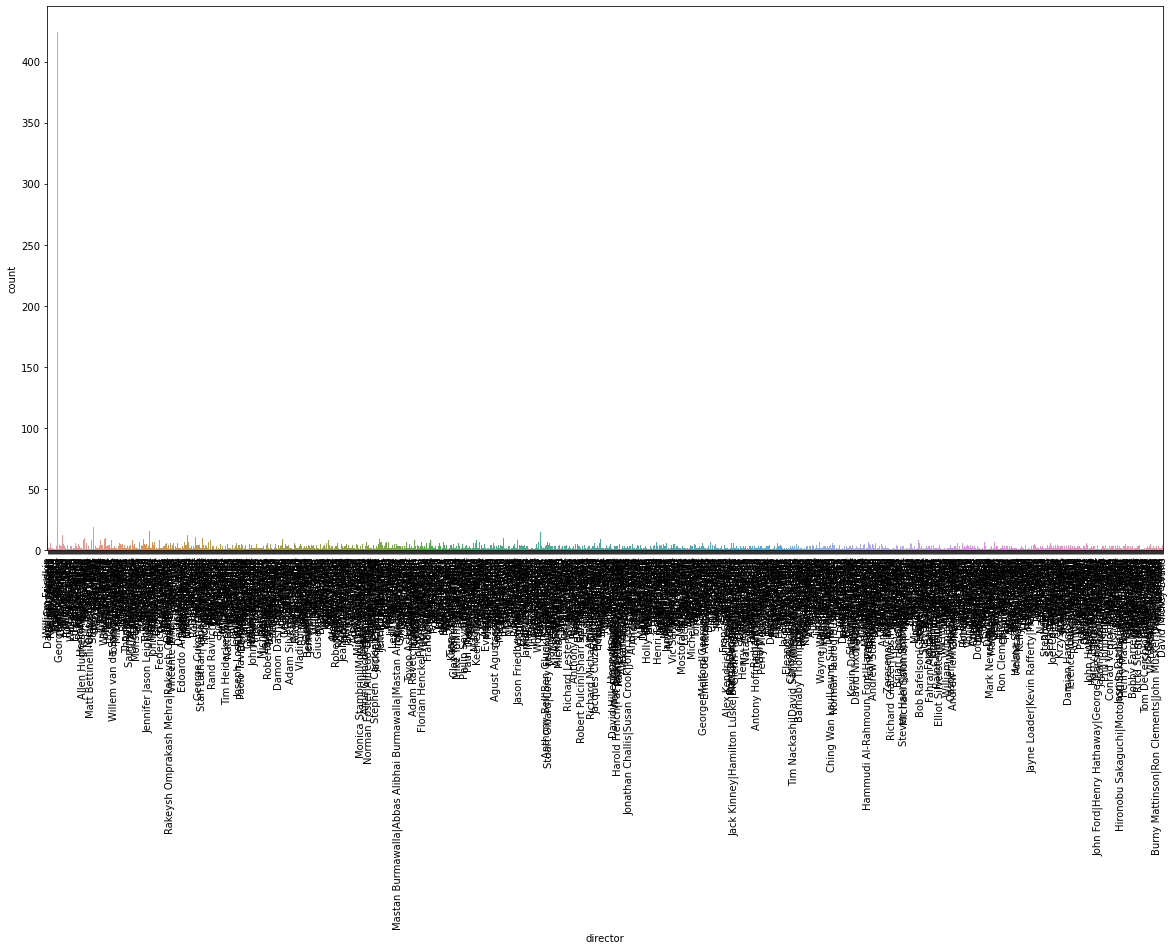

In [52]:
# # now let's visualize it
# #Plot bar graph
#Plot bar graph
# plt.figure(figsize=(12, 8))
# sns.countplot(ax=ax1,x='director', data=movie_split_genres)
# plt.xticks(rotation=35, horizontalalignment='right')
# plt.xlabel('Director')
# plt.ylabel('Number of Movies)')
# plt.title('Top Directors', fontsize=16)
# # plt.tight_layout()
# plt.show()

fig, ax1 = plt.subplots(figsize=(20,10))
graph = sns.countplot(ax=ax1,x='director'[:25], data=movie_split_genres)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90);

### Looking at tmdb data set
### tmdb Movies

In [53]:
tmdb = pd.read_csv('Data/tmdb.movies.csv', index_col=0, parse_dates=['release_date'])
tmdb

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [54]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 2.0+ MB


In [55]:
# it looks like we don't have any null values, but just to confirm:
tmdb.isna().sum()

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [56]:
tmdb.describe()

,id,popularity,vote_average,vote_count
count,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837
std,153661.615648,4.355229,1.852946,960.961095
min,27.000000,0.600000,0.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000
50%,309581.000000,1.374000,6.000000,5.000000
75%,419542.000000,3.694000,7.000000,28.000000
max,608444.000000,80.773000,10.000000,22186.000000


### Look at Movies by popularity

Top Ten movies:

In [57]:
top_ten_movies_by_pop=tmdb.pivot_table(values='popularity',index="original_title").sort_values(ascending=False,by='popularity').head(10)
top_ten_movies_by_pop

,popularity
original_title,
Avengers: Infinity War,80.773
John Wick,78.123
Spider-Man: Into the Spider-Verse,60.534
The Hobbit: The Battle of the Five Armies,53.783
The Avengers,50.289
Guardians of the Galaxy,49.606
Blade Runner 2049,48.571
Fantastic Beasts: The Crimes of Grindelwald,48.508
Ralph Breaks the Internet,48.057


Bottom Ten movies

In [58]:
Bottom_ten_movies_by_pop=tmdb.pivot_table(values='popularity',index="original_title").sort_values(ascending=True,by='popularity').head(10)
Bottom_ten_movies_by_pop

,popularity
original_title,
"""BLESSED""",0.6
Lenny Cooke,0.6
Leolex,0.6
Leonard Cohen - Songs from the Road,0.6
Leonard in Slow Motion,0.6
Leones,0.6
Leopard,0.6
Les Profs,0.6
Lemonade + Ducktape Stuffs,0.6


### Looking into release date to see if there is a certain time of the year that has higher releases

To organize our data and make it simpler to visualize, I will go ahead and drop the columns that I won't be using for better visibility

In [59]:
# Drop the irrelevant columns
drop_columns = ['original_title','original_language','genre_ids']
tmdb.drop(drop_columns, axis=1, inplace=True)
tmdb.head()

,id,popularity,release_date,title,vote_average,vote_count
0,12444,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,10191,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,10138,28.515,2010-05-07,Iron Man 2,6.8,12368
3,862,28.005,1995-11-22,Toy Story,7.9,10174
4,27205,27.920,2010-07-16,Inception,8.3,22186


In [60]:
# getting only the year in release_date to make things simpler
# Coercion is the implicit conversion of an instance of one type to another
# during an operation which involves two arguments of the same type.
tmdb['year'] = pd.to_datetime(tmdb['release_date'], errors='coerce').apply(lambda x: str(x).split('-')
                                                                       [0] if x != np.nan else np.nan)
tmdb['month'] = pd.to_datetime(tmdb['release_date'], errors='coerce').apply(lambda x: str(x).split('-')
                                                                       [1] if x != np.nan else np.nan)
tmdb

,id,popularity,release_date,title,vote_average,vote_count,year,month
0,12444,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,11
1,10191,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,03
2,10138,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,05
3,862,28.005,1995-11-22,Toy Story,7.9,10174,1995,11
4,27205,27.920,2010-07-16,Inception,8.3,22186,2010,07
...,...,...,...,...,...,...,...,...
26512,488143,0.600,2018-10-13,Laboratory Conditions,0.0,1,2018,10
26513,485975,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,2018,05
26514,381231,0.600,2018-10-01,The Last One,0.0,1,2018,10
26515,366854,0.600,2018-06-22,Trailer Made,0.0,1,2018,06
